# Migration in the Swedish Parliament

- Date: 2019-02-20
- Source: Kungliga Biblioteket

## Preparations
As the dataset is too large for version control, here are the steps neccessary to recreate the chart below.

1. Create a new directory `<path to weekly charts>/data/kb`.
1. Go to [Riksdagstryck](https://data.kb.se/datasets/2017/09/riksdagstryck/) and download [tvåkammarriksdagen-1867-1970-motioner.zip](https://data.kb.se/datasets/2017/09/riksdagstryck/tv%C3%A5kammarriksdagen-1867-1970-motioner.zip).
1. Extract the archive and move all text files to a new subdirectory `<path to weekly charts>/data/kb/historical`.
1. Go to [Riksdagens öppna data](http://data.riksdagen.se/data/dokument/) and download everything under "Motion" (1971-2021) as text files.
1. For each archive from Riksdagen, extract it and move it to a new subfolder `<path to weekly charts>/data/kb/current`.

You end up with the following structure:

    - data
        - kb
            - historical
                - <around 77 500 text files>
            - current
                - mot-1971-1979.text
                    - <around 20 000 text files>
                - mot-1980-1989.text
                    - <around 33 000 text files>
                ...

After the above steps are completed, the data should load without any issues in the script below.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from src.plot import ds_style

%config InlineBackend.figure_format = 'retina'

if 'datastory' in plt.style.available:
    plt.style.use('datastory')

## Load data

In [2]:
# Change path to wherever your documents are stored
path = '../data/kb'

In [3]:
def load(pat):
    fnames = glob(f'{path}/{pat}')
    data = [{'name': f, 'text': open(f).read()} for f in fnames]
    return pd.DataFrame(data)

In [4]:
new = load(pat='current/*.text/*.txt')
old = load(pat='historical/*.txt')

## Extract metadata

Refer to [Så funkar dokument-id](http://data.riksdagen.se/dokumentation/sa-funkar-dokument-id/) for more information about document identifiers.

In [5]:
def format_name(ser):
    name = ser.name.str.split('/')
    name = name.str[-1].str.replace('.txt', '')
    return name

def extract_doc_id(ser):
    doc_id = ser.name.str.split('-')
    doc_id = doc_id.apply(lambda x: x[-1])
    return doc_id

def extract_year(ser):
    try:
        year = ser.name.str[:4].astype(int)
    except ValueError:
        year = -1
    return year

def extract_chamber(ser):
    return ser.name.str.extract('_([af]k)_')

def extract_meeting(ser):
    return ser.doc_id.str[:2]

def extract_series(ser):
    return ser.doc_id.str[2:4]

def extract_no(ser):
    return ser.doc_id.str[4:]

def clean_docs(df):
    return (df
        .assign(name=format_name)
        .assign(year=extract_year)
        .assign(doc_id=extract_doc_id)
        .assign(chamber=extract_chamber)
        .assign(meeting=extract_meeting)
        .assign(series=extract_series)
        .assign(no=extract_no))

In [6]:
old = old.pipe(clean_docs)
new = new.pipe(clean_docs)

In [7]:
# Extract year from newer documents
meetings_url = 'http://data.riksdagen.se/dokumentation/sa-funkar-dokument-id/'
meetings = pd.read_html(meetings_url, header=0)[0]
meetings = meetings.set_index('Tecken')['Riksmöte/år'].to_dict()

new['year'] = (new['meeting']
    .str.upper()
    .map(meetings)
    .str.split('/', expand=True)[0])

In [8]:
df = pd.concat([old, new], sort=True)
df.year = df.year.astype(float).astype('Int64')

## Word counts

In [9]:
def count_words(df, regexes, labels, as_frac=True):
    counts = []
    years = df.groupby('year').size()
    for r, l in zip(regexes, labels):
        df[l] = df.text.str.contains(r, case=False)
        yearly_counts = df.groupby('year')[l].sum()
        yearly_counts.index = yearly_counts.index.astype(int)
        if as_frac:
            yearly_totals = df.groupby('year').size()
            yearly_counts = yearly_counts / yearly_totals
        counts.append(yearly_counts)
    counts = pd.concat(counts, axis=1, sort=True)
    counts.columns = labels
    return counts

In [10]:
counts = df.pipe(count_words,
                 regexes=['utvandr|emigr', 'invandr|immigr'],
                 labels=['Emigration', 'Immigration'])

## Plot

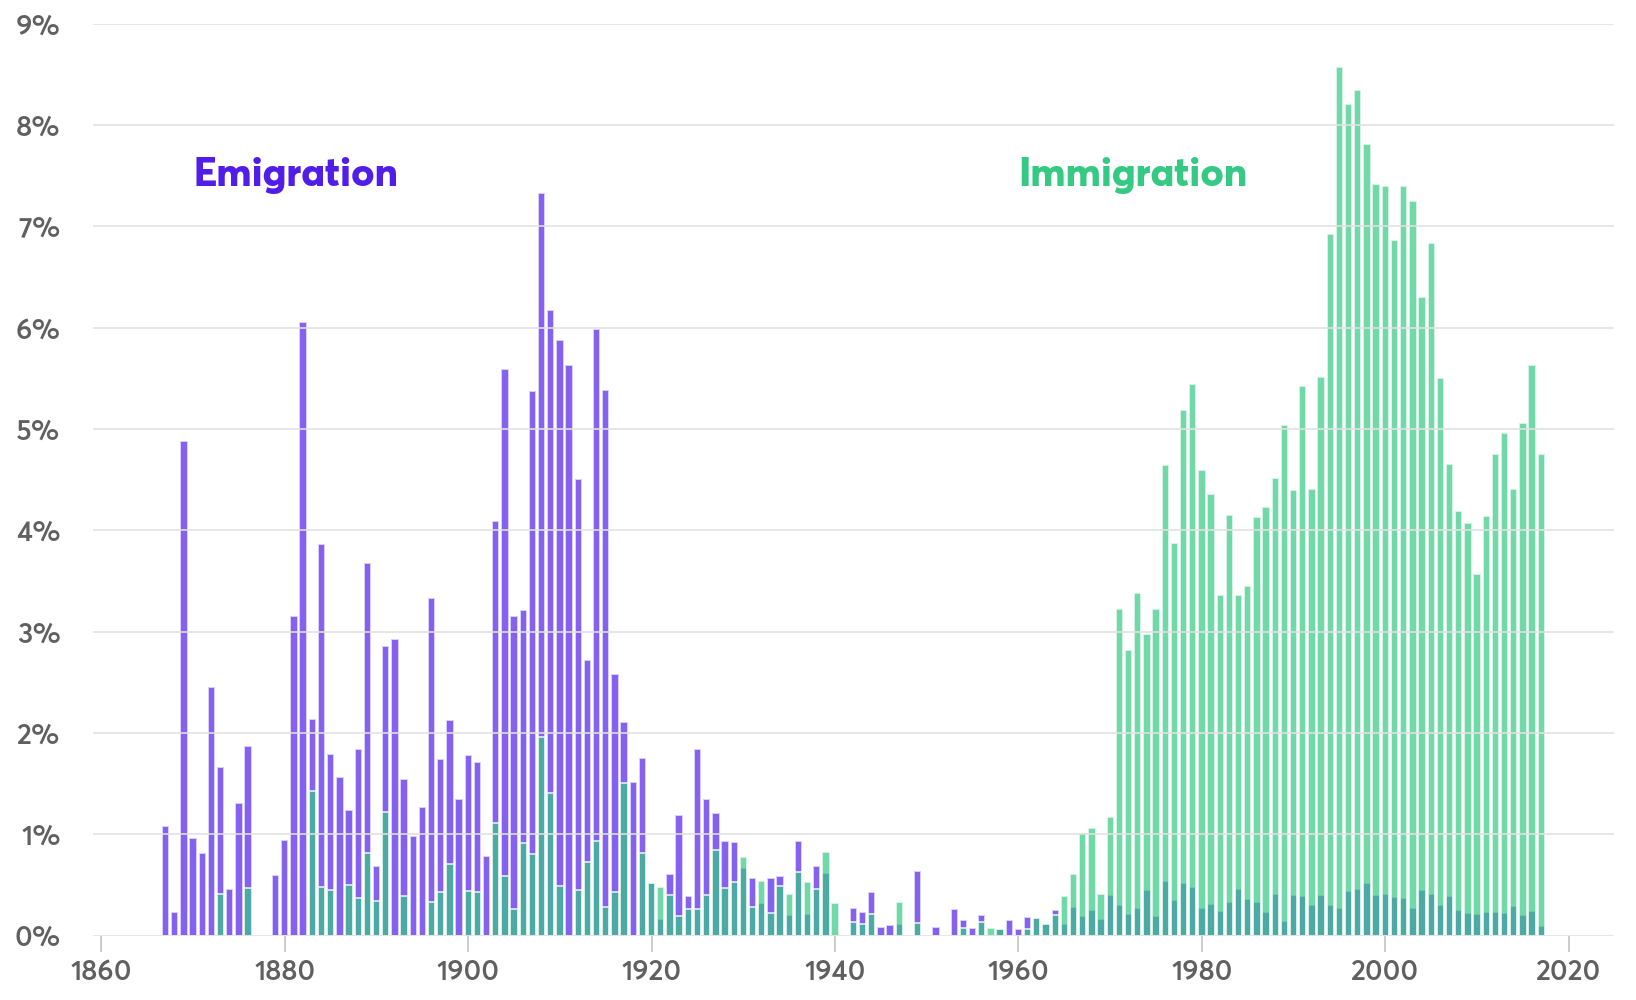

In [11]:
w = 12
h = w * 0.597
figsize = (w, h)

fig, ax = plt.subplots(figsize=figsize)
plt.tight_layout(rect=(0.05, 0.02, 1, 1))

textargs = {'size': 20, 'weight': 'bold', 'ha': 'left',
            'backgroundcolor': '#ffffff'}
barargs = {'alpha': 0.7, 'ec': '#ffffff'}

ax.bar(counts.index, counts['Emigration'], color='#511ee9', **barargs)
ax.bar(counts.index, counts['Immigration'], color='#35c983', **barargs)

ax.text(1960, 0.074, 'Immigration', color='#35c983', **textargs)
ax.text(1870, 0.074, 'Emigration', color='#511ee9', **textargs)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

ds_style(ax);